# Exploring your Home Assistant data

The goal of this page is to get you familiar with the data in your Home Assistant instance. The page you're reading right now is a Jupyter Notebook. These documents contain instructions for the user and embedded Python code to generate graphs and tables of your data. It's interactive so you can at any time change the code of any example and just press the ▶️ button to update the example with your changes! 

To get started, let's execute all examples on this page: in the menu at the top left, click on "Run" -> "Run All Cells".

In [1]:
#!pip install HASS-data-detective # Install detective

In [2]:
!pip show HASS-data-detective

Name: HASS-data-detective
Version: 2.4
Summary: Tools for studying Home Assistant data.
Home-page: https://github.com/robmarkcole/HASS-data-detective
Author: Robin Cole
Author-email: robmarkcole@gmail.com
License: MIT
Location: /usr/local/lib/python3.9/dist-packages
Requires: pandas, pytz, ruamel.yaml, SQLAlchemy
Required-by: 


In [3]:
import detective.core as detective
import detective.functions as functions
import pandas as pd

db = detective.db_from_hass_config()

Successfully connected to database sqlite:////config/home-assistant_v2.db
There are 221 entities with data


## Popular entities

In the following example, we're going to explore your most popular entities and break it down per period of the day (morning/afternoon/evening/night).

We will do this by looking at which services are getting called and which entities they targeted. To make the results more relevant, we will filter out any service call that happened because of another service call. So if a user turns on a script which turns on a light, we only count the interaction with the script and not with the light.

In [4]:
from collections import Counter, OrderedDict
import json

from detective.time import time_category, sqlalch_datetime, localize, TIME_CATEGORIES

# Prepare a dictionary to track results
results = OrderedDict((time_cat, Counter()) for time_cat in TIME_CATEGORIES)

# We keep track of contexts that we processed so that we will only process
# the first service call in a context, and not subsequent calls.
context_processed = set()

for event in db.perform_query("SELECT * FROM events WHERE event_type = 'call_service' ORDER BY time_fired"):
    entity_ids = None

    # Skip if we have already processed an event that was part of this context
    if event.context_id in context_processed:
        continue

    try:
        event_data = json.loads(event.event_data)
    except ValueError:
        continue

    # Empty event data, skipping (shouldn't happen, but to be safe)
    if not event_data:
        continue

    service_data = event_data.get('service_data')

    # No service data found, skipping
    if not service_data:
        continue

    entity_ids = service_data.get('entity_id')

    # No entitiy IDs found, skip this event
    if entity_ids is None:
        continue

    if not isinstance(entity_ids, list):
        entity_ids = [entity_ids]

    context_processed.add(event.context_id)

    period = time_category(
        localize(sqlalch_datetime(event.time_fired)))

    for entity_id in entity_ids:
        results[period][entity_id] += 1

print("Most popular entities to interact with:")

RESULTS_TO_SHOW = 5

for period, period_results in results.items():
    print()
    
    entities = [
        ent_id for (ent_id, count)
        in period_results.most_common(RESULTS_TO_SHOW)
    ]
    
    result = ', '.join(entities) if entities else '-'
    print(f"{period.capitalize()}: {result}")

Most popular entities to interact with:

Morning: light.office_lamp, light.lamp, scene.all_lights_off, light.sitting_room_lamp, light.sitting_room

Daytime: light.lamp, light.sitting_room, light.office_lamp, light.bedroom_3, media_player.living_room_speaker

Evening: light.lamp, light.office_lamp, light.sitting_room, light.sitting_room_lamp, switch.charles_blanket

Night: light.lamp, climate.house_absolute, light.office_lamp, light.bedroom_1, switch.tasmota


### Next up

Let's now use pandas to visualise the results.

In [5]:
df = pd.DataFrame.from_dict(results).fillna(0)
df

,morning,daytime,evening,night
light.bedroom_1,4.0,7.0,4.0,6.0
light.bedroom_2,1.0,7.0,4.0,3.0
light.bedroom_3,1.0,15.0,4.0,3.0
light.lamp,17.0,63.0,67.0,36.0
scene.all_lights_off,12.0,12.0,5.0,1.0
light.office_lamp,19.0,24.0,35.0,18.0
light.sitting_room,7.0,44.0,31.0,3.0
light.sitting_room_lamp,8.0,6.0,25.0,1.0
light.kitchen,2.0,0.0,3.0,0.0
climate.house_absolute,0.0,2.0,12.0,35.0


## View states
Detective makes it easy to view your state data as a pandas dataframe.

In [25]:
%%time

df = db.fetch_all_data_of(['sensor.dishwasher_energy_power'])

The returned Pandas dataframe has 1192 rows of data.
CPU times: user 41.9 ms, sys: 8.29 ms, total: 50.2 ms
Wall time: 49.2 ms


Our data is now in a Pandas dataframe. Lets show the head of the dataframe:

In [26]:
df.head()

,domain,entity_id,state,last_changed,attributes
0,sensor,sensor.dishwasher_energy_power,0,2022-01-04 14:25:31.958880,"{""state_class"":""measurement"",""unit_of_measurem..."
1,sensor,sensor.dishwasher_energy_power,0,2022-01-04 14:20:31.940321,"{""state_class"":""measurement"",""unit_of_measurem..."
2,sensor,sensor.dishwasher_energy_power,0,2022-01-04 14:15:25.936812,"{""state_class"":""measurement"",""unit_of_measurem..."
3,sensor,sensor.dishwasher_energy_power,0,2022-01-04 14:10:25.943993,"{""state_class"":""measurement"",""unit_of_measurem..."
4,sensor,sensor.dishwasher_energy_power,0,2022-01-04 14:05:25.928019,"{""state_class"":""measurement"",""unit_of_measurem..."


It is necessary to do some formatting of the data before we can plot it, and detective provides several functions to assist. You should familiarise yourself with these functions and create your own.

In [27]:
df = functions.generate_features(df)
df = functions.format_dataframe(df)
df = df.set_index('last_changed')

In [28]:
df.head()

,domain,entity_id,state,attributes,device_class,unit_of_measurement,friendly_name
last_changed,,,,,,,
2022-01-04 14:25:31.958880,sensor,sensor.dishwasher_energy_power,0,"{'state_class': 'measurement', 'unit_of_measur...",power,W,Dishwasher ENERGY Power
2022-01-04 14:20:31.940321,sensor,sensor.dishwasher_energy_power,0,"{'state_class': 'measurement', 'unit_of_measur...",power,W,Dishwasher ENERGY Power
2022-01-04 14:15:25.936812,sensor,sensor.dishwasher_energy_power,0,"{'state_class': 'measurement', 'unit_of_measur...",power,W,Dishwasher ENERGY Power
2022-01-04 14:10:25.943993,sensor,sensor.dishwasher_energy_power,0,"{'state_class': 'measurement', 'unit_of_measur...",power,W,Dishwasher ENERGY Power
2022-01-04 14:05:25.928019,sensor,sensor.dishwasher_energy_power,0,"{'state_class': 'measurement', 'unit_of_measur...",power,W,Dishwasher ENERGY Power


Notice the new feature columns added. It is straightforward to create your own features, for example to add a day_of_week column

<AxesSubplot:xlabel='last_changed'>

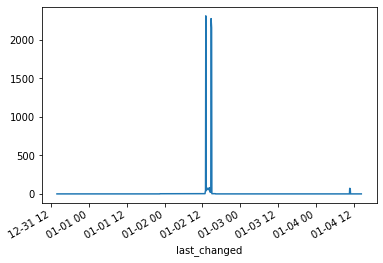

In [29]:
df['state'].plot()

In [11]:
df.head()

,domain,entity_id,state,last_changed,attributes,device_class,unit_of_measurement,friendly_name,day_of_week
0,sensor,sensor.house_absolute_humidity,46.10,2021-12-21 17:46:03.188912,"{'state_class': 'measurement', 'time': '2021-1...",humidity,%,House Absolute humidity,1
1,sensor,sensor.house_absolute_temperature,21.73,2021-12-21 17:46:03.188479,"{'state_class': 'measurement', 'time': '2021-1...",temperature,°C,House Absolute temperature,1
2,sensor,sensor.bedroom_switch_battery_level,82.00,2021-12-21 17:45:53.909084,"{'state_class': 'measurement', 'battery_state'...",battery,%,Bedroom switch Battery,1
3,sensor,sensor.kitchen_motion_sensor_temperature,19.90,2021-12-21 17:45:44.879011,"{'state_class': 'measurement', 'temperature_va...",temperature,°C,Kitchen motion sensor Temperature,1
5,sensor,sensor.kitchen_motion_sensor_light_level,99.00,2021-12-21 17:44:34.144867,"{'state_class': 'measurement', 'light_level': ...",illuminance,lx,Kitchen motion sensor Illuminance,1


## Plot some data
First plot using [Seaborn](https://seaborn.pydata.org/)

In [12]:
#!pip install seaborn # Uncomment to install if required

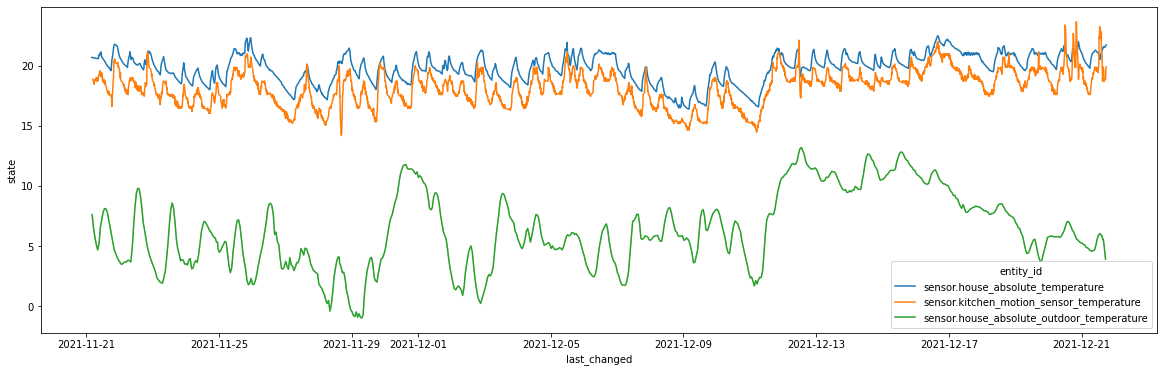

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(20,6))
sns.lineplot(
    x='last_changed', 
    y='state', 
    hue='entity_id', 
    data=df[df['device_class'] == 'temperature'], 
    ax=ax);